# 1. Изменение эмоций с помощью Vanilla Autoencoder

## 1.1. Подготовка данных


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import os


from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import skimage.io
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from IPython.display import clear_output


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

## 1.2. Архитектура модели



In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):

        # <определите архитектуры encoder и decoder>

    def __init__(self,
                 in_channels: int,
                 dim_code: int):

        super(Autoencoder, self).__init__()

        self.dim_code = dim_code

        self.flatten = nn.Flatten()

        # encoder
        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=32,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU(inplace=True),
                    nn.Conv2d(32, out_channels=64,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU(inplace=True),
                    nn.Conv2d(64, out_channels=128,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU(inplace=True),
                    nn.Conv2d(128, out_channels=256,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(256),
                    nn.Tanh()
        )
        self.linear = nn.Linear(4096, self.dim_code)

        # decoder
        self.decoder_input = nn.Linear(self.dim_code, 4096)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,
                                128,
                                kernel_size=3,
                                stride = 2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(128,
                                64,
                                kernel_size=3,
                                stride = 2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64,
                                32,
                                kernel_size=3,
                                stride = 2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(32,
                                32,
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, out_channels= 3,
                        kernel_size= 3, padding= 1)

        )

    def forward(self, x):

       # encoding

        x = x.permute(0, 3, 1, 2).float()
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)

        latent_code = self.linear(x)

        # decoding
        x = self.decoder_input(latent_code)
        x = x.view(-1, 256, 2, 2)
        x = self.decoder(x)
        reconstruction = torch.sigmoid(x)

        return reconstruction, latent_code

    def sample(self, z):
        generated = self.decoder_input(z)
        generated = generated.view(-1, 256, 2, 2)
        generated = self.decoder(generated)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 64, 64, 3)
        return generated

    def find_latent_code(self, x):
        x = x.permute(0, 3, 1, 2).float()
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)

        latent_code = self.linear(x)
        return latent_code


In [ ]:
criterion = F.mse_loss

dim_code = 16

autoencoder = Autoencoder(3, dim_code).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 1e-3)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [5, 10, 15, 20, 25, 30, 35, 40, 45], gamma = 0.5)

## 1.3 Обучение

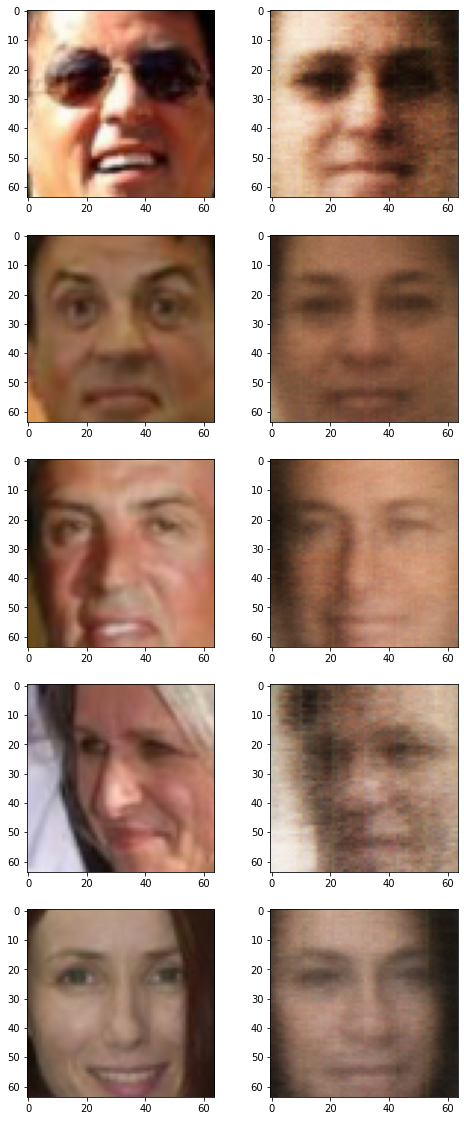

latent_code:  tensor(-0.5789, device='cuda:0', grad_fn=<MeanBackward0>) tensor(6.8856, device='cuda:0', grad_fn=<StdBackward0>)



In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, latent_code = autoencoder(batch.to(device).to(device))
        reconstruction = reconstruction.reshape(-1, 64, 64, 3)
        loss = criterion(reconstruction, batch.to(device).float())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
            optimizer.zero_grad()
            reconstruction, _ = autoencoder(batch.to(device).to(device))
            reconstruction = reconstruction.reshape(-1, 64, 64, 3)
            loss = criterion(reconstruction, batch.to(device).float())
            result = reconstruction.cpu().detach().numpy()
            ground_truth = batch.numpy()

            val_losses_per_epoch.append(loss.item())
    scheduler.step()

    with torch.no_grad():
        for batch in val_loader:
            reconstruction, _ = autoencoder(batch.to(device))
            reconstruction = reconstruction.view(-1, 64, 64, 3)
            result = reconstruction.cpu().detach().numpy()
            ground_truth = batch.numpy()
            break


    clear_output(wait=True)
    plt.figure(figsize=(8, 20))
    for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
        plt.subplot(5, 2, 2*i+1)
        plt.imshow(gt)
        plt.subplot(5, 2, 2*i+2)
        plt.imshow(res)
    plt.show()

    #для определения распределения рандомных изображейний
    print("latent_code: ", latent_code.mean(), latent_code.std())
    mu, sigma = latent_code.mean(), latent_code.std()
    val_losses.append(np.mean(val_losses_per_epoch))

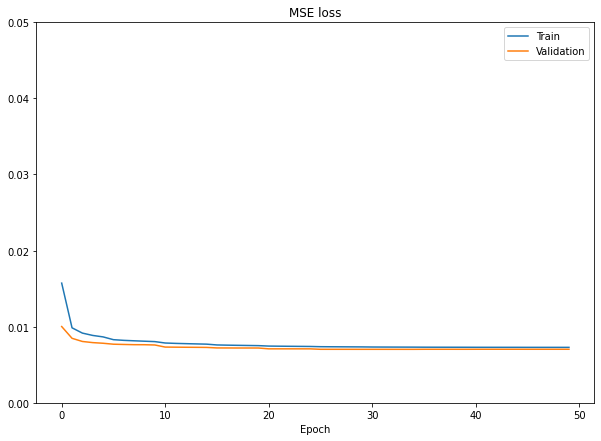

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [ ]:
  autoencoder.eval()
  with torch.no_grad():
      for batch in val_loader:
        reconstruction, _ = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break



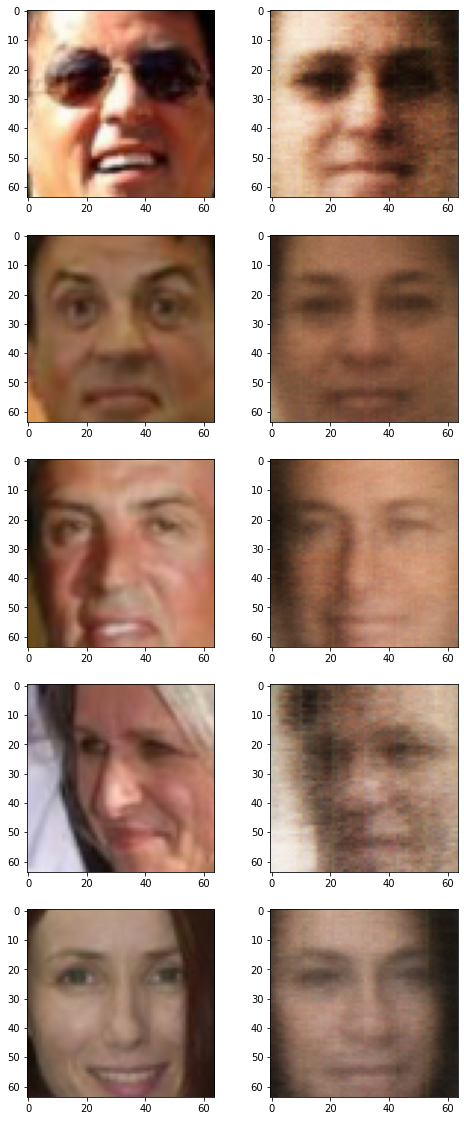

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

## 1.4. Sampling

Генерация новых лиц) декодер создает изображения из случайного вектора

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space

z = torch.FloatTensor(np.random.normal(mu.cpu().detach().numpy(), sigma.cpu().detach().numpy(), (25, dim_code)))
print(z.size())
output = autoencoder.sample(torch.FloatTensor(z).to(device))


torch.Size([25, 16])


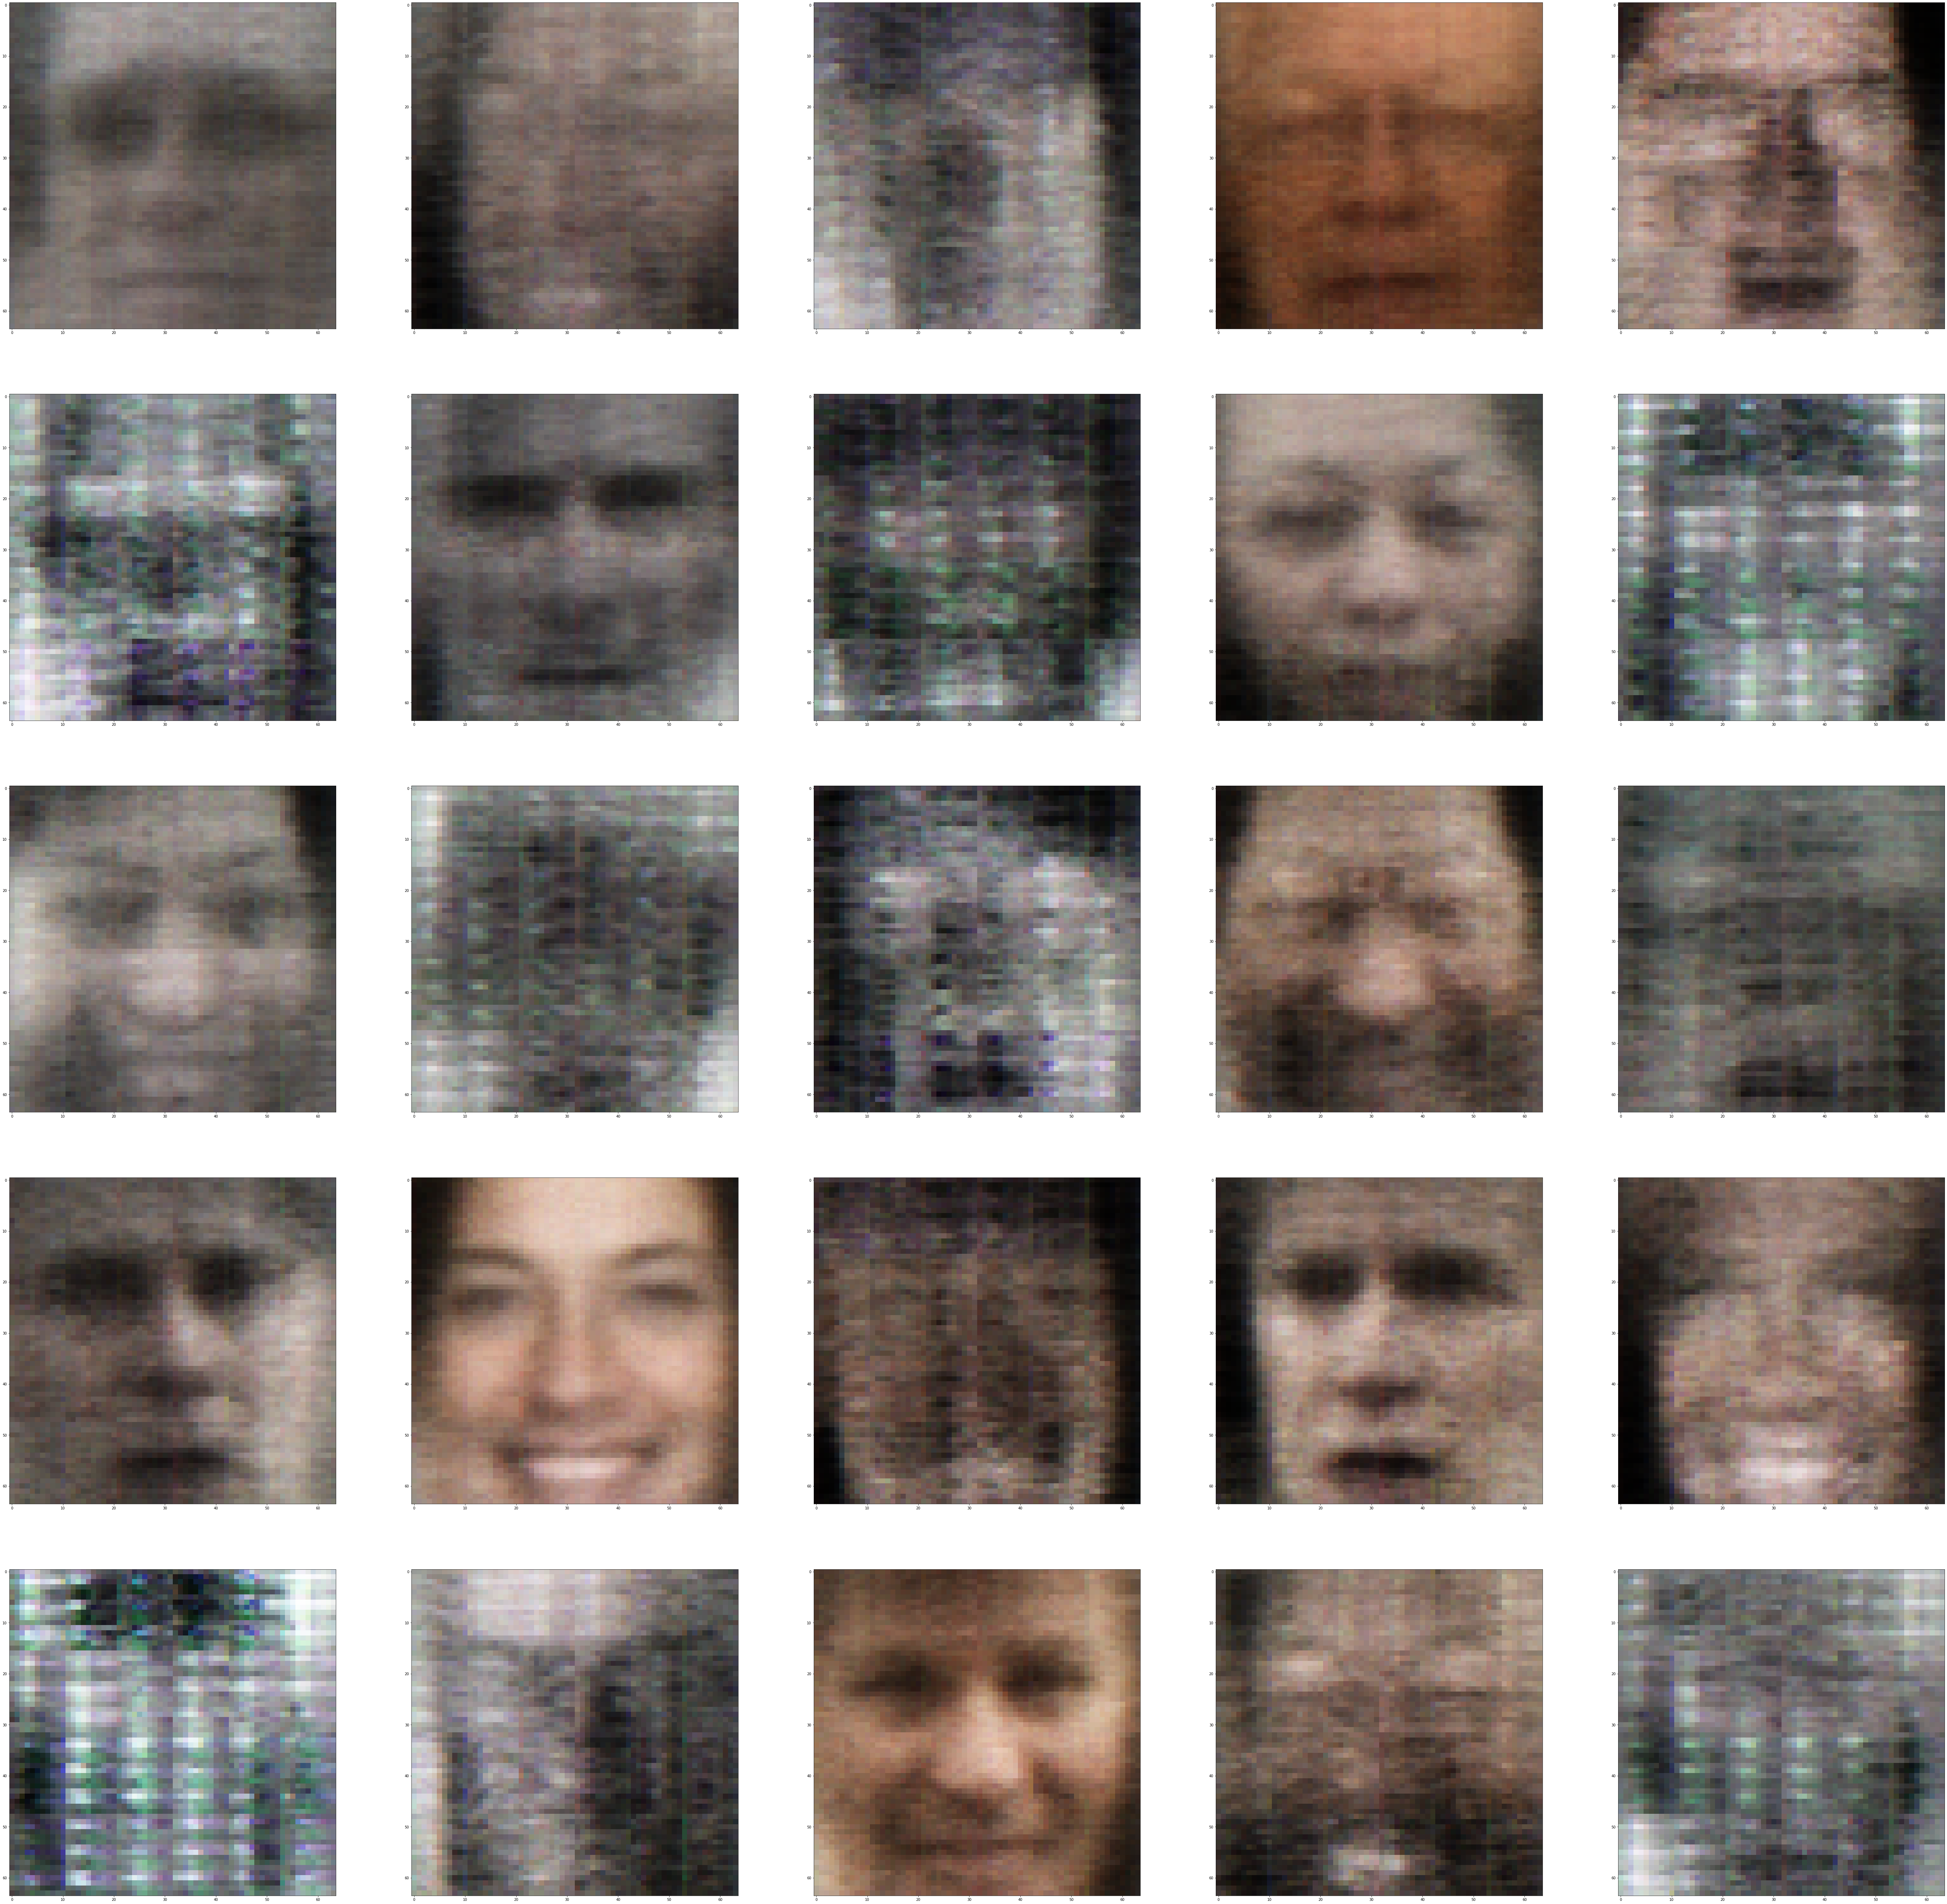

In [ ]:
plt.figure(figsize=(100, 100))
for i in range(output.shape[0]):
  plt.subplot(5, 5, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()

## Улыбок тебе дед Макар!

Как это работает:

1. Выделяется "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

2. Вычисляется латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислияется, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smiling_faces = []
for i, attr in enumerate(attrs["Smiling"]):
    if attr >= 2.6:
        smiling_faces.append(data[i])
smiling_faces = torch.tensor(smiling_faces).to(device)
smiling = autoencoder.find_latent_code(smiling_faces)

In [ ]:
smiling_vector = smiling.mean(dim=0)

In [ ]:
sad_faces = []
for i, attr in enumerate(attrs["Smiling"]):
    if attr <= -2.5:
        sad_faces.append(data[i])
sad_faces = torch.tensor(sad_faces).to(device)
sad = autoencoder.find_latent_code(sad_faces)

In [ ]:
sad_vector = sad.mean(0)

In [ ]:
sad_vector - smiling_vector

tensor([ -4.7999,  -1.4679,   6.3905,  -1.9925,   2.7863,   5.0300,   1.2063,
         -2.6275,   6.6713,   5.5273,   5.9920,  -0.0872, -11.9955,   2.1582,
          2.4813,   4.4297], device='cuda:0', grad_fn=<SubBackward0>)

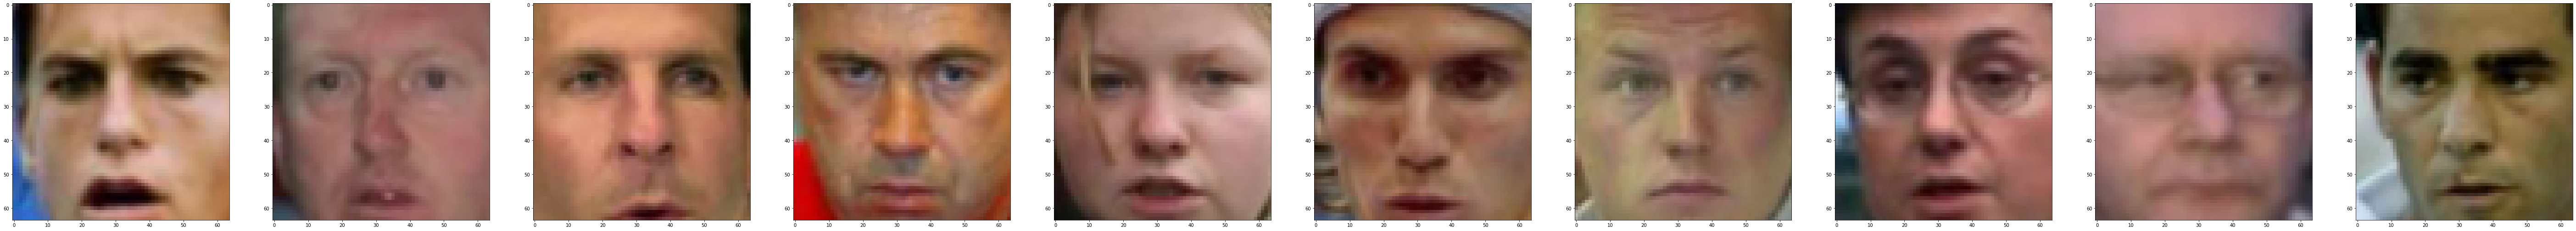

In [ ]:
plt.figure(figsize=(100, 100))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(sad_faces[i].cpu())


plt.show()

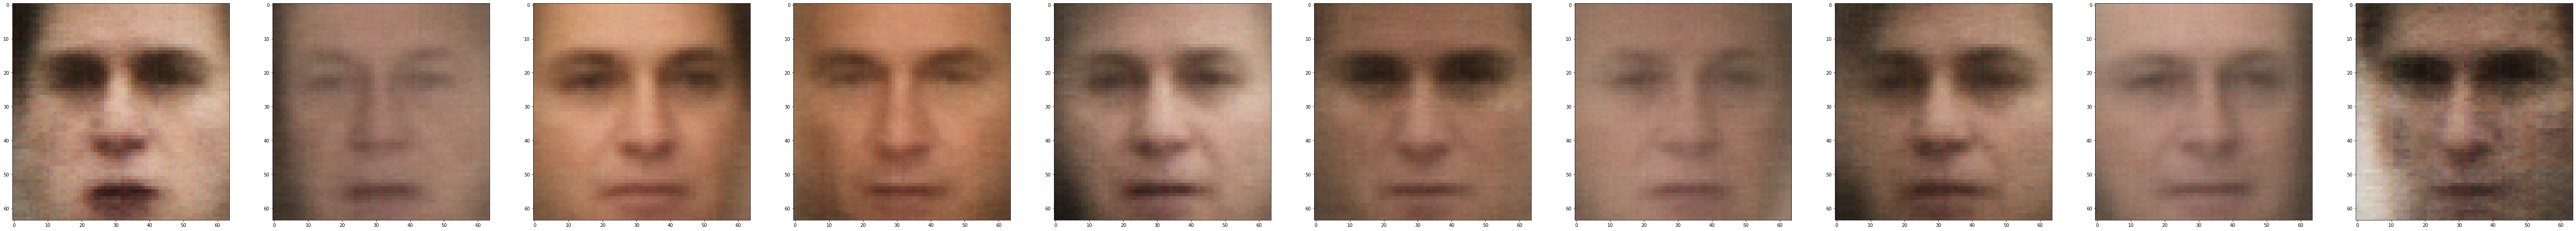

In [ ]:
output = autoencoder.sample(sad)

plt.figure(figsize=(100, 100))
for i in range(10):
  plt.subplot(2, 10, i+1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()

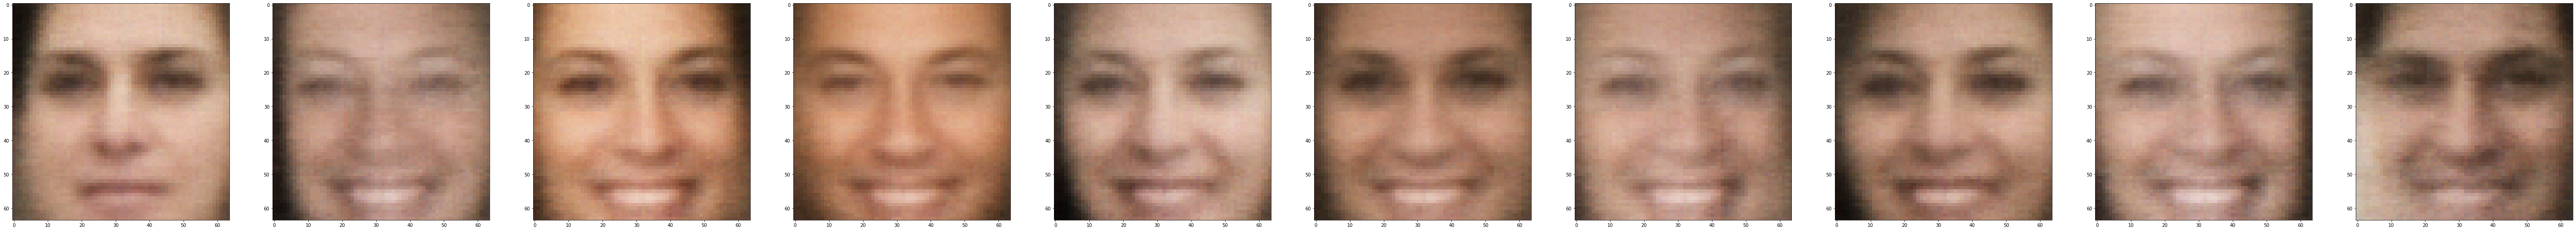

In [ ]:
output = autoencoder.sample(sad.sub(sad_vector - smiling_vector))

plt.figure(figsize=(100, 100))
for i in range(10):
  plt.subplot(2, 10, i+1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()

# Часть 2: Variational Autoencoder

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=torchvision.transforms.ToTensor(), download=False)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2.1 Архитектура модели и обучение



In [ ]:
class VAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 dim_code: int):

        super(VAE, self).__init__()

        self.dim_code = dim_code

        self.flatten = nn.Flatten()

        # encoder
        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=8,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(8),
                    nn.LeakyReLU(),
                    nn.Conv2d(8, out_channels=16,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(16)
        )
        self.fc_mu = nn.Linear(784, self.dim_code)
        self.fc_logsigma = nn.Linear(784, self.dim_code)



        # decoder
        self.decoder_input = nn.Linear(self.dim_code, 784)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,
                                8,
                                kernel_size=3,
                                stride = 2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8,
                                1,
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU())





    def encode(self, x):

        x = self.encoder(x)

        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):

        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu

    def decode(self, z):

        z = self.decoder_input(z)
        z = z.view(-1, 16, 7, 7)
        z = self.decoder(z)
        reconstruction = torch.sigmoid(z)

        return reconstruction

    def forward(self, x):

        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent_code)

        return reconstruction, mu, logsigma

    def sample(self, latent_code):
        generated = self.decode(latent_code)
        return generated

    def find_latent_code(self, x):
        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        return latent_code


Функции потерь

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    loss = loss(reconstruction, x)
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Обучение модели

In [ ]:
criterion = loss_vae
latent = 64
autoencoder = VAE(1, latent).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 20], gamma = 0.1)

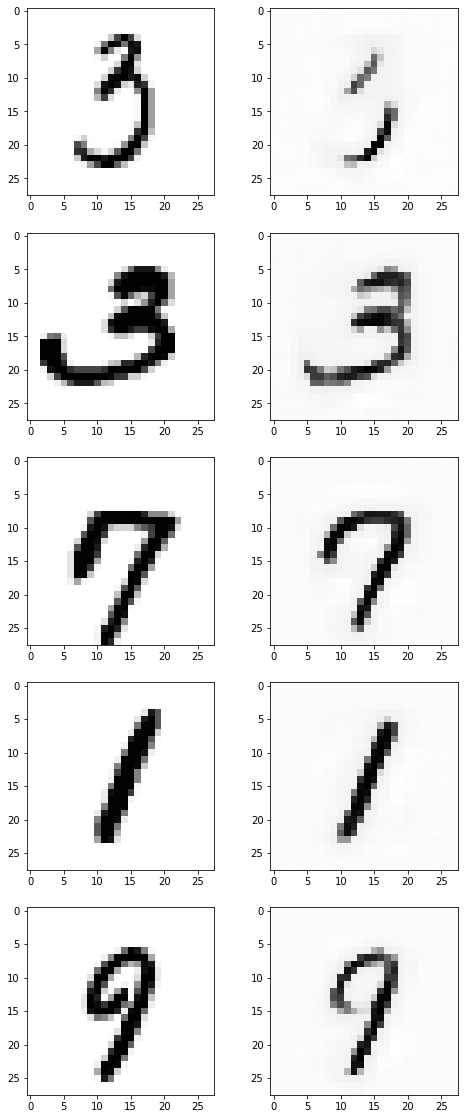

In [ ]:
n_epochs = 30
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_losses_per_epoch))


    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
            optimizer.zero_grad()
            reconstruction, mu, logsigma = autoencoder(batch[0].to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)




            val_losses_per_epoch.append(loss.item())

    scheduler.step()

    val_losses.append(np.mean(val_losses_per_epoch))

    #Визуализация

    with torch.no_grad():
        for batch in train_loader:
            reconstruction, _, _ = autoencoder(batch[0].to(device))
            reconstruction = reconstruction.permute(0,2,3,1)
            result = reconstruction.cpu().detach().numpy()
            ground_truth = batch[0].permute(0,2,3,1).numpy()
            break


    clear_output(wait=True)
    plt.figure(figsize=(8, 20))
    for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
        plt.subplot(5, 2, 2*i+1)
        plt.imshow(gt.reshape(28, 28), cmap=plt.cm.Greys)
        plt.subplot(5, 2, 2*i+2)
        plt.imshow(res.reshape(28, 28), cmap=plt.cm.Greys)
    plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
        reconstruction, _, _ = autoencoder(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch[0].permute(0,2,3,1).numpy()
        break

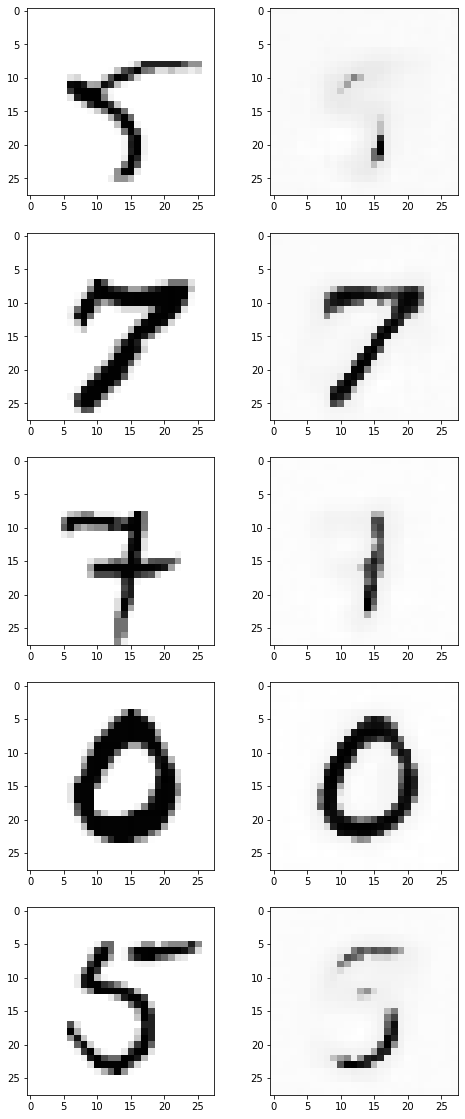

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt.reshape(28, 28), cmap=plt.cm.Greys)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res.reshape(28, 28), cmap=plt.cm.Greys)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
        latent = autoencoder.find_latent_code(batch[0].to(device))
        print(latent.mean(), latent.std())
        break

tensor(0.0078, device='cuda:0') tensor(0.6068, device='cuda:0')


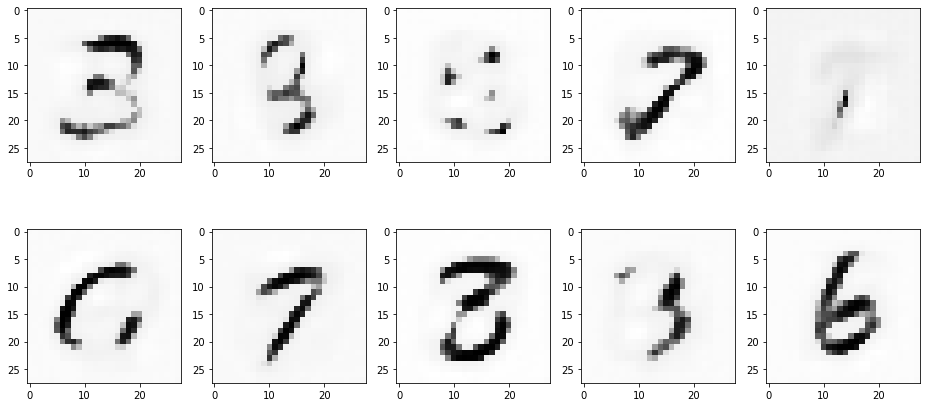

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
num_examples = 10
z = np.array([np.random.normal(0, 1, 32) for i in range(num_examples)])
z = torch.FloatTensor(z).to(device)
output = autoencoder.sample(z)
output = output.cpu().detach().numpy()
plt.figure(figsize=(16, 40))
for i, res in enumerate(output):
    plt.subplot(num_examples, 5, i+1)
    plt.imshow(res.reshape(28, 28), cmap=plt.cm.Greys)

## 2.2. Latent Representation

Задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

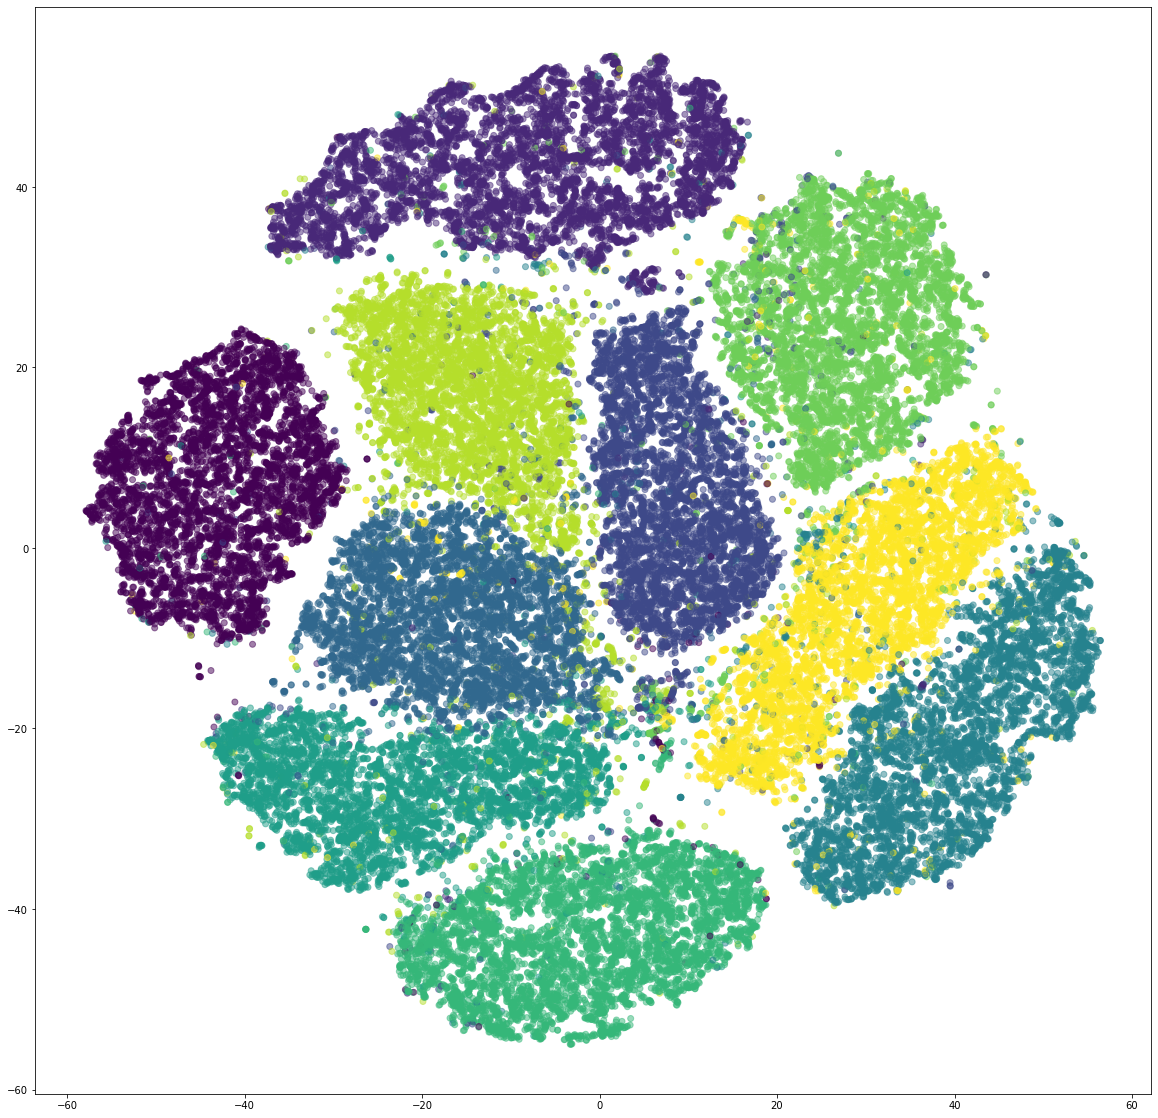

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


autoencoder.eval()
latent = []
latent_label = []

with torch.no_grad():
    for batch in train_loader:
        latent.append(autoencoder.find_latent_code(batch[0].to(device)))
        latent_label.append(batch[1])
latent = torch.cat(latent)
latent_label = torch.cat(latent_label)


latent2d = TSNE(n_components=2).fit_transform(latent.cpu().detach().numpy())
latent2d.shape


latent2d = TSNE(n_components=2).fit_transform(latent.cpu().detach().numpy())
latent2d.shape


plt.figure(figsize=(20,20))
x = latent2d.transpose()[0]
y = latent2d.transpose()[1]
colors = latent_label.cpu().detach().numpy()

plt.scatter(x, y, c=colors, alpha=0.5)
plt.show()

## 2.3. Conditional VAE


Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

### Архитектура



In [ ]:
# загружаю датасет с one-hot labels
batch_size = 32
# MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=True,
                                 transform=torchvision.transforms.ToTensor(),
                                 target_transform=torchvision.transforms.Compose([
                                 lambda x:torch.tensor([x]), # or just torch.LongTensor
                                 lambda x:F.one_hot(x,10)]),
                                 download=True)

test_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=False,
                                 transform=torchvision.transforms.ToTensor(),
                                 target_transform=torchvision.transforms.Compose([
                                 lambda x:torch.tensor([x]), # or just torch.LongTensor
                                 lambda x:F.one_hot(x,10)]),
                                 download=False)

# Data Loader (Input Pipeline)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class CVAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 dim_code: int):

        super(CVAE, self).__init__()

        self.dim_code = dim_code

        self.embed_class = nn.Linear(10, 28 * 28)
        self.embed_data = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.flatten = nn.Flatten()

        # encoder
        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels*2, out_channels=8,
                              kernel_size= 3, stride= 2, padding  = 1),
                    # nn.BatchNorm2d(8),
                    nn.LeakyReLU(),
                    nn.Conv2d(8, out_channels=16,
                              kernel_size= 3, stride= 2, padding  = 1),
                    # nn.BatchNorm2d(16)
        )
        self.fc_mu = nn.Linear(784, self.dim_code)
        self.fc_logsigma = nn.Linear(784, self.dim_code)



        # decoder
        self.decoder_input = nn.Linear(self.dim_code + 10, 784)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,
                                8,
                                kernel_size=3,
                                stride = 2,
                                padding=1,
                                output_padding=1),
            # nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8,
                                1,
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=1),
            # nn.BatchNorm2d(1),
            nn.LeakyReLU())





    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
        # x = x.permute(0, 3, 1, 2).float()

        x = self.encoder(x)

        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):

        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        # print('decoder_input', z.size())
        z = self.decoder_input(z)
        z = z.view(-1, 16, 7, 7)
        z = self.decoder(z)
        reconstruction = torch.sigmoid(z)

        return reconstruction

    def forward(self, input, labels):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>

        embedded_class = self.embed_class(labels)
        embedded_class = embedded_class.view(-1, 28, 28).unsqueeze(1)
        embedded_input = self.embed_data(input)
        x = torch.cat([embedded_input, embedded_class], dim = 1)
        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        latent_code = torch.cat([latent_code, labels], dim = 1)
        reconstruction = self.decode(latent_code)

        return reconstruction, mu, logsigma

    def sample(self, latent_code, label):
        latent_code = torch.cat([latent_code, label], dim = 1)
        generated = self.decode(latent_code)
        return generated

    def find_latent_code(self, input, labels):
        embedded_class = self.embed_class(labels)
        embedded_class = embedded_class.view(-1, 28, 28).unsqueeze(1)
        embedded_input = self.embed_data(input)
        x = torch.cat([embedded_input, embedded_class], dim = 1)
        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        latent_code = torch.cat([latent_code, labels], dim = 1)
        return latent_code


In [ ]:
criterion = loss_vae

autoencoder = CVAE(1, 32).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 1e-3)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [4, 8], gamma = 0.1)

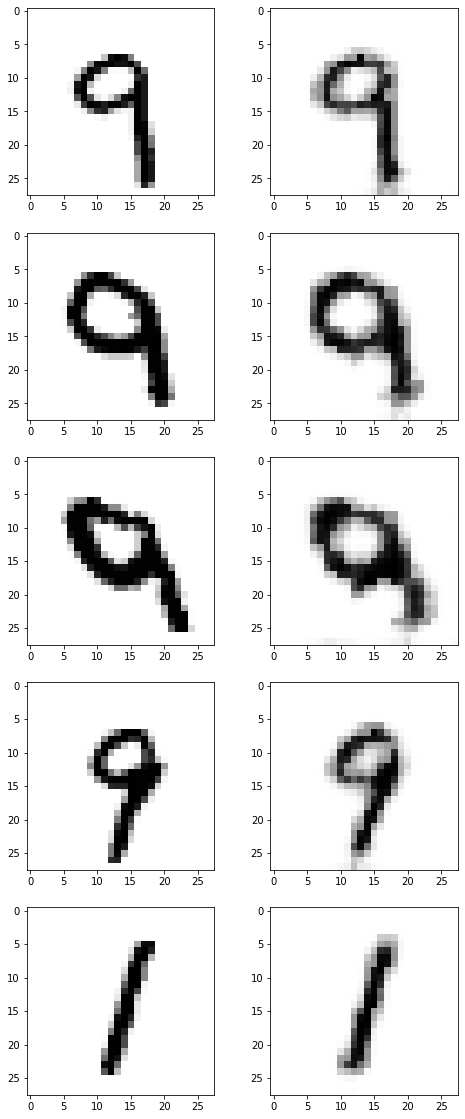

In [ ]:
n_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch[0].to(device), batch[1].float().view(-1, 10).to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_losses_per_epoch))





    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
            optimizer.zero_grad()
            reconstruction, mu, logsigma = autoencoder(batch[0].to(device), batch[1].float().view(-1, 10).to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)




            val_losses_per_epoch.append(loss.item())

    scheduler.step()

    val_losses.append(np.mean(val_losses_per_epoch))

    #Визуализация

    with torch.no_grad():
        for batch in train_loader:
            reconstruction, _, _ = autoencoder(batch[0].to(device), batch[1].float().view(-1, 10).to(device))
            reconstruction = reconstruction.permute(0,2,3,1)
            result = reconstruction.cpu().detach().numpy()
            ground_truth = batch[0].permute(0,2,3,1).numpy()
            break


    clear_output(wait=True)
    plt.figure(figsize=(8, 20))
    for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
        plt.subplot(5, 2, 2*i+1)
        plt.imshow(gt.reshape(28, 28), cmap=plt.cm.Greys)
        plt.subplot(5, 2, 2*i+2)
        plt.imshow(res.reshape(28, 28), cmap=plt.cm.Greys)
    plt.show()

### Sampling


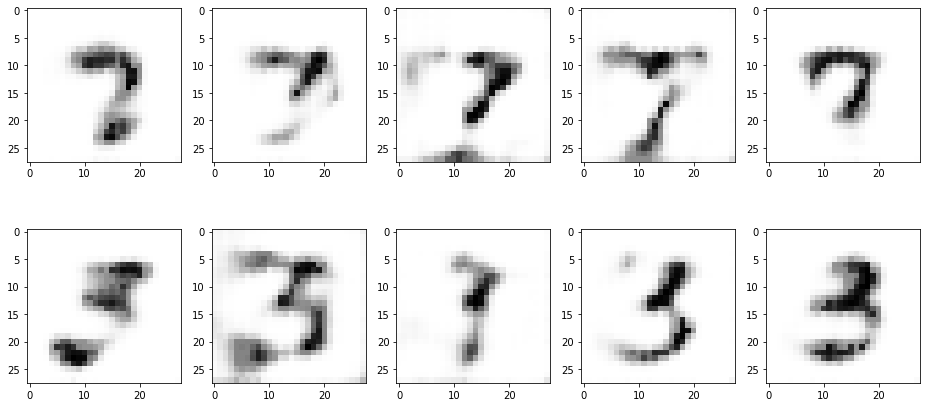

In [ ]:
num_examples = 10
z = np.array([np.random.normal(0, 0.5, 32) for i in range(num_examples)])
z = torch.FloatTensor(z).to(device)
label = torch.cat([torch.FloatTensor([[0,0,0,0,0,0,0,1,0,0] for i in range(num_examples//2)]),
                torch.FloatTensor([[0,0,0,1,0,0,0,0,0,0] for i in range(num_examples//2)])], dim =0).to(device)
output = autoencoder.sample(z, label)
output = output.cpu().detach().numpy()
plt.figure(figsize=(16, 40))
for i, res in enumerate(output):
    plt.subplot(num_examples, 5, i+1)
    plt.imshow(res.reshape(28, 28), cmap=plt.cm.Greys)

### Latent Representations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
# на этом участке кода крашит ноутбук

autoencoder.eval()
latent = []
latent_label = []

i = 0
with torch.no_grad():
    for batch in test_loader:
        latent.append(autoencoder.find_latent_code(batch[0].to(device), batch[1].float().view(-1, 10).to(device)))
        latent_label.append(batch[1].argmax(dim = -1))
latent = torch.cat(latent)
latent_label = torch.cat(latent_label)



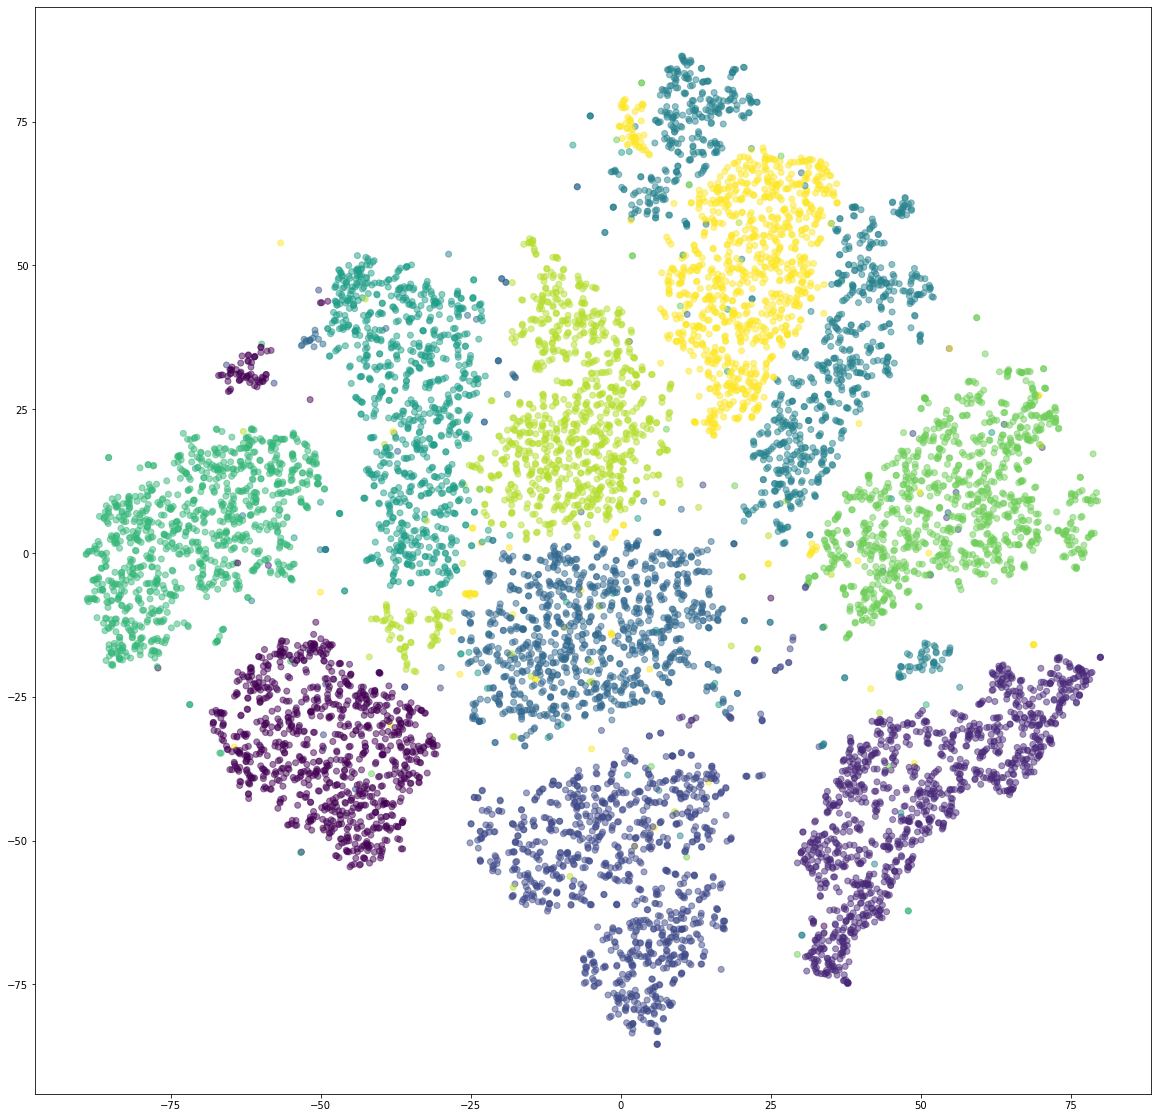

In [ ]:
latent2d = TSNE(n_components=2).fit_transform(latent.cpu().detach().numpy())

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.figure(figsize=(20,20))
x = latent2d.transpose()[0]
y = latent2d.transpose()[1]
colors = latent_label.cpu().detach().numpy()
plt.scatter(x, y, c=colors, alpha=0.5)
plt.show()